# Import libraries

In [1]:
import os
import re
import copy

import pandas as pd
import numpy as np
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load and align all dataframes

In [2]:
chexpert_categories = ["No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly",
                      "Lung Lesion", "Lung Opacity", "Edema", "Consolidation",
                      "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
                      "Pleural Other", "Fracture", "Support Devices"]

# reports
val = pd.read_csv('../data_msc_project/cheXpert/input_chexpert.csv', header=None)
val.columns = ['id', 'text']

# chexbert
# df_chexbert = pd.read_csv('../data_msc_project/bertdata/batch64-please4-bluebert-chexset-chexblabeled/eval.csv')
df_chexbert = pd.read_csv('../data_msc_project/bertdata/fixed-train-dev/bertbase-chexset-chexplabeled/output.csv')
df_chexbert = df_chexbert.merge(
    val, how='inner', left_on='Report Impression', right_on='text'
)
df_chexbert.drop_duplicates(inplace=True)
# Drop the 's' in the beginning of the id
df_chexbert['id'] = df_chexbert['id'].astype(str).str.lstrip('s')
df_chexbert.set_index('id', inplace=True)
df_chexbert.rename(columns={'Airspace Opacity': 'Lung Opacity'}, inplace=True)
df_chexbert = df_chexbert[chexpert_categories]

# chexpert
df_chexpert = pd.read_csv('../data_msc_project/cheXpert/chexpert_labeled_1.csv')
df_chexpert = df_chexpert.merge(
    val, how='inner', left_on='Reports', right_on='text'
)
df_chexpert.drop_duplicates(inplace=True)
# Drop the 's' in the beginning of the id
df_chexpert['id'] = df_chexpert['id'].astype(str).str.lstrip('s')
df_chexpert.set_index('id', inplace=True)
df_chexpert.rename(columns={'Airspace Opacity': 'Lung Opacity'}, inplace=True)
df_chexpert = df_chexpert[chexpert_categories]

# ground truth
gs = pd.read_csv('../data_msc_project/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.1.0-test-set-labeled.csv', header=0, index_col=0)
gs.index.name = 'id'
gs.rename(columns={'Airspace Opacity': 'Lung Opacity'}, inplace=True)
gs = gs[chexpert_categories]

print(gs.shape)

# ensure all dataframes are aligned
gs.sort_index(inplace=True)
gs.index = gs.index.astype(str)
common_indices = gs.index.intersection(df_chexpert.index)
gs = gs.loc[common_indices]
df_chexpert = df_chexpert.loc[common_indices]
df_chexbert = df_chexbert.loc[common_indices]

(687, 14)


In [3]:
# Replace NaN with 2
df_chexbert.fillna(2, inplace=True)
gs.fillna(2, inplace=True)


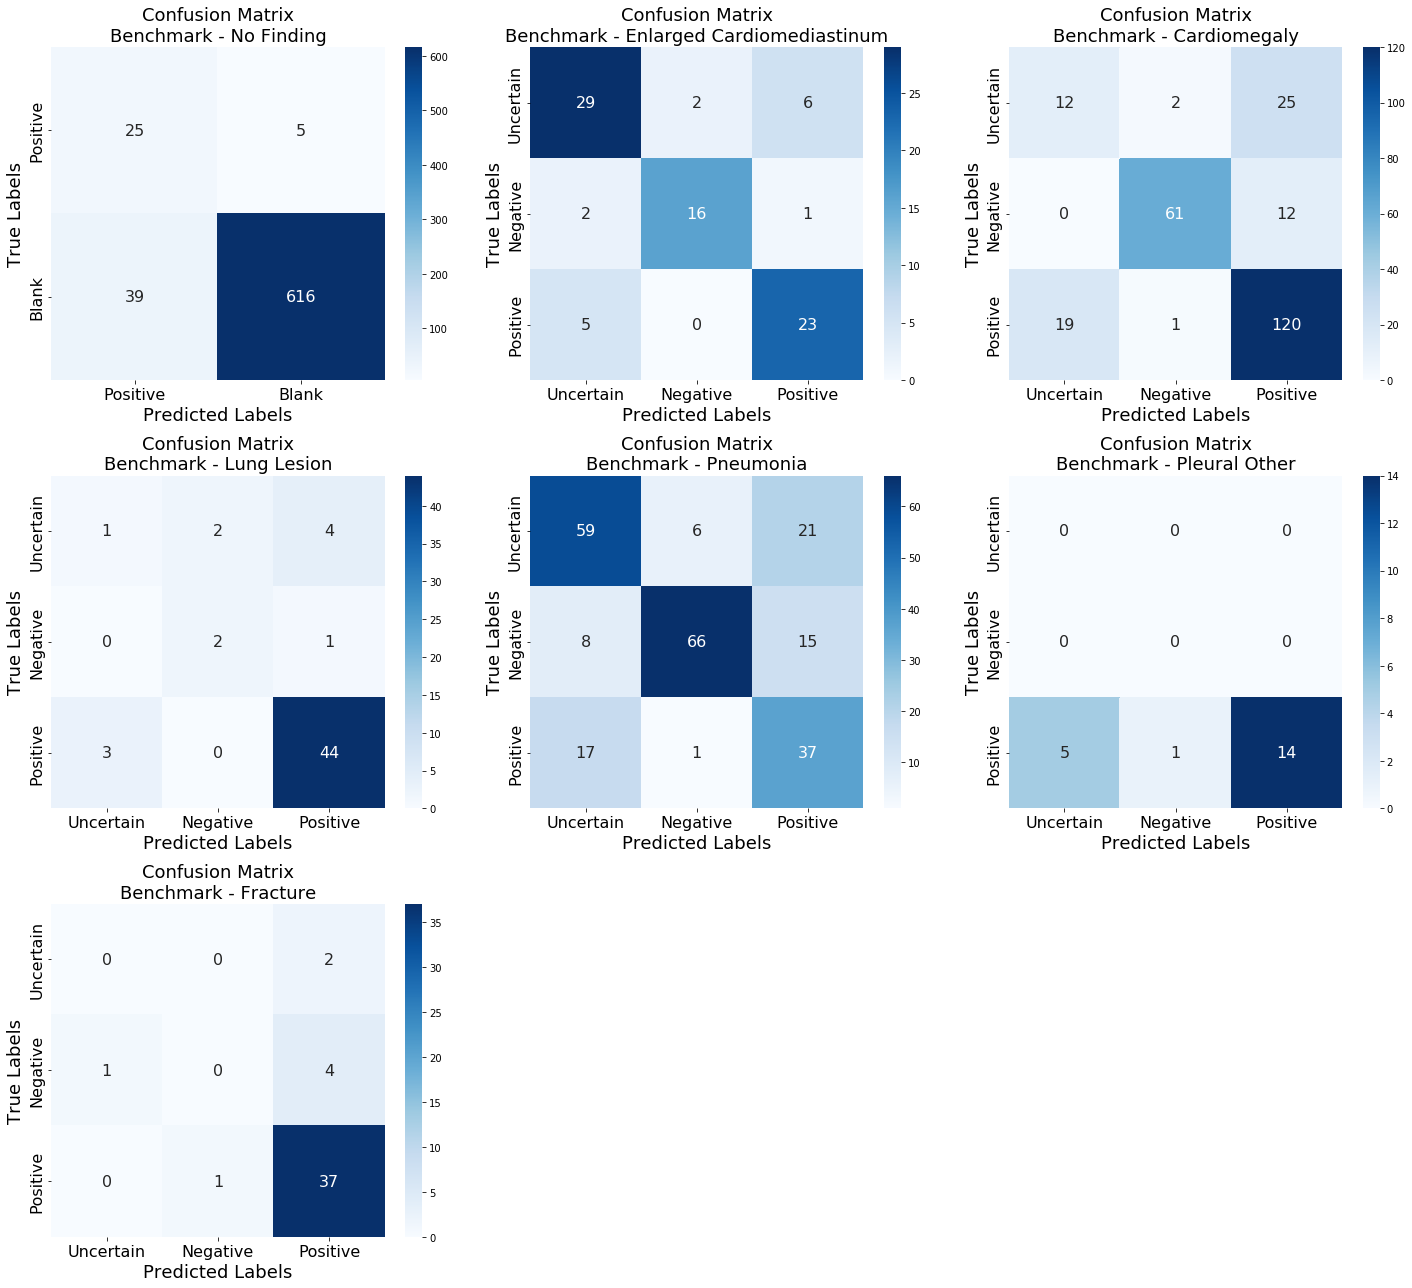

In [9]:
# Define the function to plot confusion matrices for multiple categories
def plot_all_confusion_matrices(pred, ground_truth, model_name, categories):
    # Determine the number of rows needed (ceil of 14/4)
    n_categories = len(categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols  # This is equivalent to math.ceil(n_categories / n_cols)

    # Set up the plot grid: dynamic number of rows with 4 columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, category in enumerate(categories):
        ax = axes[i]  # Get the corresponding axis
        # Plot confusion matrix for each category
        plot_confusion_matrix(pred, ground_truth, model_name, ax=ax, category=category)
        
    # Hide any unused subplots
    if len(categories) < len(axes):
        for j in range(len(categories), len(axes)):
            fig.delaxes(axes[j])  # Remove the extra axis

    plt.tight_layout()
    plt.show()

# Modify the plot_confusion_matrix function to take an axis argument
def plot_confusion_matrix(pred, ground_truth, model_name, ax=None, blank=False, category=''):
    if category != '':
        pred = pred[category]
        ground_truth = ground_truth[category]

    df1 = pred.copy()
    df2 = ground_truth.copy()

    df1.fillna(2, inplace=True)
    df2.fillna(2, inplace=True)

    # Flatten the DataFrames to 1D arrays
    df1_flat = df1.values.flatten()
    df2_flat = df2.values.flatten()

    if blank:
        cm = confusion_matrix(df2_flat, df1_flat, labels=[-1, 0, 1, 2])
        labels = ["Uncertain", "Negative", "Positive", "Blank"]
    else:
        cm = confusion_matrix(df2_flat, df1_flat, labels=[-1, 0, 1])
        labels = ["Uncertain", "Negative", "Positive"]

    if category == 'No Finding':
        cm = confusion_matrix(df2_flat, df1_flat, labels=[1, 2])
        labels = ["Positive", "Blank"]

    # Plot the confusion matrix on the provided axis
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax, annot_kws={"size": 16})
    ax.set_xlabel('Predicted Labels', fontsize=18)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_xticks(np.arange(len(labels)) + 0.5)
    ax.set_yticks(np.arange(len(labels)) + 0.5)
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_yticklabels(labels, fontsize=16)
    ax.set_title('Confusion Matrix\n' + model_name + ' - ' + category, fontsize=18)

# List of categories (clinical findings)
# categories = [
#     'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion',
#     'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
#     'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
# ]
categories = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Pneumonia', 'Pleural Other', 'Fracture',
]

# Example usage
# Assuming df_chexpert and gs are pandas DataFrames containing the predictions and ground truth labels
plot_all_confusion_matrices(df_chexbert, gs, 'Benchmark', categories)
